# USA Recession Predictor (with US Economic Data publicly available)

## Motivation
With the economic uncertainty at the end of 2022, people are anxious about the economic outlook for 2023 and if there is a recession on the horizon. In this analysis, I am attempting to answer the following questions
1. How well we can build the recession predictor with the publicly available data?
2. What are the key factors to predict recession?
3. What is the prediction for recession in 2023 using the selected models?

## Development Approach

### a) Data Preparation
1. Load data & clean date field
2. Prepare quarterly datasets
3. Prepare monthly datasets
4. Create the monthly merged dataset with 6-mth adv predictor field as target varible
5. Create the quarterly merged dataset with 2-qtr adv predictor field as target varible
6. Create the monthy and quarterly datasets with "%age change" variables and remove nulls

### b) Model Development
7. Create the clean monthly and quarterly datasets for model fitting
8. Build the Logistic regression models on monthly and quarterly datasets for recession prediction
9. Analyze the metrics for the models and answer Q1
10. Analyze the model coefficients and answer Q2

### c) 2023 Predictions
11. Load the 2022 datasets, generate 2023 predictions and answer Q3

In [100]:
# import the required packages
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Following Functions are included in this notebook
1. quarter2month_data - This functions convert the data with quarterly grain to monthly (by replicating monthly data)
2. month2quarter_data - This functions convert the data with monthly grain to quaterly (by taking mean)
3. fit_logistic_regression - This function fits the Logistic Regression model 
4. plot_log_model_coefficients - This function plot the logistic regression model coefficients

In [101]:
# Function to convert quarterly to monthly

def quarter2month_data(df, date_field, value_field):
    '''
    INPUT
    df - pandas dataframe in qaurterly format
    date_field - string providing name of date field
    value_field - string providing name of the value field to be copied
    
    OUTPUT
    m_df - pandas dataframe in monthly format with quarterly data copied
    
    '''
    m_df = df.copy()
    m_df['ind'] = np.arange(m_df.shape[0])
    m_df.index = pd.to_datetime(m_df[date_field])
    mask = m_df['ind'].duplicated(keep='last')
    m_df = pd.concat([m_df, m_df[~mask].rename(lambda x: x + pd.DateOffset(months=2))])
    m_df = m_df.groupby('ind')[value_field].resample('MS').first().ffill().reset_index()
    m_df.drop(columns='ind',inplace = True)
    
    m_df[date_field] = (m_df[date_field].astype(str)).astype(object)
    
    return m_df

In [102]:
# Function to convert monthly to quarterly


def month2quarter_data(df, date_field):
    '''
    INPUT
    df - pandas dataframe in monthly format
    date_field - string providing name of date field
    
    OUTPUT
    q_df - pandas dataframe in quaterly format with the mean of quarter
    
    '''
    q_df = df.groupby(pd.PeriodIndex(df[date_field], freq="Q"), axis=0).mean()
    q_df.index = q_df.index.to_timestamp()
    q_df.index.names = [date_field]
    q_df.reset_index(inplace=True)
    q_df[date_field] = (q_df[date_field].astype(str)).astype(object)
    
    return q_df

In [103]:
# Function to initiate and fit logistic regresssion model

def fit_logistic_regression(df, target_field, test_split):
    '''
    INPUT
    df - pandas dataframe in monthly format
    target_field - target variable
    test_split - the %age of test vs train split
    
    
    OUTPUT
    X_train - training dataset
    X_test - test dataset
    y_train - training target vector
    y_test - test target vector
    preds - predicted target vector for X_test
    lg_model - fitted logistic regression model
    accuracy - accuracy score of the fitted model
    
    '''
    X = df.drop(target_field,axis=1)
    y = df[target_field]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=42)
    
    # set the max_iter to 1000 because the default 100 was not converging
    log_mod = LogisticRegression(solver='lbfgs', max_iter=1000)
    log_mod.fit(X_train, y_train)
    preds = log_mod.predict(X_test)

    score = log_mod.score(X_test, y_test)
           
           
    return X_train, X_test, y_train, y_test,preds, log_mod, score

In [104]:
# Function to plot logistic regresssion model coefficients

def plot_log_model_coefficients(log_mod,cols, title,clr='blue'):
    
    '''
    INPUT
    log_mod - fitted logistic regression model
    cols - list of column names
    title - title of the graph
    clr - color of the bar chart
    
    
    OUTPUT
    None
    
    '''
    ind = np.arange(len(cols))
    log_odds = log_mod.coef_[0]
    plot_df = pd.DataFrame(log_odds,cols, columns=['coef']).sort_values(by='coef', ascending=False)
    
    ax1 = plot_df.plot.bar(rot=0,color=clr,figsize=(10, 8))
    bars = ax1.bar(ind, plot_df['coef'],color=clr)
    ax1.bar_label(bars, label_type='center')
    ax1.set_title(title)
    
    
 


## 1-  Load and clean the the following datasets 
1. Recession data
2. Gross Domestic Product (GDP) data
3. Consumer Price Index (CPI) data
4. Gold Futures Price data 
5. Unemployment Rate data
6. Federal Funds Rate (Interest Rate) data
7. Down Jones Index (DJI) data
9. Housing Price Index (HPI) data

In [105]:
# Read the datasets
# ** Recession Data **
recession_df = pd.read_csv('./data/JHDUSRGDPBR.csv')
# ** GDP trend Data **
gdp_df = pd.read_csv('./data/A191RL1Q225SBEA.csv')
# ** Consumer Pricing Index data **
cpi_df = pd.read_csv('./data/CORESTICKM159SFRBATL.csv')
# ** Gold Future Price historical (per ounce) data **
gold_df = pd.read_csv('./data/Gold_futures_price.csv')
# ** Unemployment data **
unemp_df = pd.read_csv('./data/UNRATE.csv')
# ** Interest rate data **
interest_df = pd.read_csv('./data/FEDFUNDS.csv')
# ** Dow Jones Industrial Average Index data **
dji_df = pd.read_csv('./data/DJI_Average.csv')
# ** Housing Pricing Index data **
hpi_df = pd.read_csv('./data/USSTHPI.csv')


print("Size of recession dataset : {}".format(recession_df.shape[0]))
print("Size of gdp dataset : {}".format(gdp_df.shape[0]))
print("Size of cpi dataset : {}".format(cpi_df.shape[0]))
print("Size of gold price dataset : {}".format(gold_df.shape[0]))
print("Size of unemployment index dataset : {}".format(unemp_df.shape[0]))
print("Size of interest rate dataset : {}".format(interest_df.shape[0]))
print("Size of Dow Jones Index dataset : {}".format(dji_df.shape[0]))
print("Size of Housing Price Index dataset : {}".format(hpi_df.shape[0]))

Size of recession dataset : 219
Size of gdp dataset : 302
Size of cpi dataset : 659
Size of gold price dataset : 575
Size of unemployment index dataset : 898
Size of interest rate dataset : 820
Size of Dow Jones Index dataset : 717
Size of Housing Price Index dataset : 190


In [106]:
# Clean the gold and dji datasets

# ********* DJI DATASET ************
# 1- Date Field clean up: 11/01/2022 -> dji
dji_df['DATE'] = (pd.to_datetime(dji_df['Date']).astype(str)).astype(object)
new_col = dji_df.columns[-1:].tolist() + dji_df.columns[:-1].tolist()
dji_df = (dji_df[new_col]).drop(columns='Date')
#2- drop the unwanted columns
dji_df = dji_df.drop(['Price', 'Open', 'High', 'Low', 'Vol.'] , axis=1)
#3- convert the %age change field to numeric/fload instead of string
dji_df['Change %'] = (dji_df['Change %'].str.rstrip('%')).astype(float)

# ********* DJI DATASET ************
# 1- Date Field clean up: 11/01/2022 -> gold
gold_df['DATE'] = (pd.to_datetime(gold_df['Date']).astype(str)).astype(object)
new_col = gold_df.columns[-1:].tolist() + gold_df.columns[:-1].tolist()
gold_df = (gold_df[new_col]).drop(columns='Date')
#2- convert the price field to float
gold_df['Price'] = (gold_df['Price'].str.replace(',','')).astype(float)


## 2- Prepare quarterly datasets

In [107]:
# Prepare the quarterly datasets

q_recession_df = recession_df.copy()
q_gdp_df = gdp_df.copy()
q_hpi_df = hpi_df.copy()
q_cpi_df = month2quarter_data(cpi_df, 'DATE')
q_gold_df = month2quarter_data(gold_df, 'DATE')
q_unemp_df = month2quarter_data(unemp_df, 'DATE')
q_interest_df = month2quarter_data(interest_df, 'DATE')
q_dji_df = month2quarter_data(dji_df, 'DATE')


print("Size of qaurterly recession dataset : {}".format(q_recession_df.shape[0]))
print("Size of qaurterly gdp dataset : {}".format(q_gdp_df.shape[0]))
print("Size of qaurterly cpi dataset : {}".format(q_cpi_df.shape[0]))
print("Size of qaurterly gold price dataset : {}".format(q_gold_df.shape[0]))
print("Size of qaurterly unemployment index dataset : {}".format(q_unemp_df.shape[0]))
print("Size of qaurterly interest rate dataset : {}".format(q_interest_df.shape[0]))
print("Size of qaurterly Dow Jones Index dataset : {}".format(q_dji_df.shape[0]))
print("Size of qaurterly Housing Price Index dataset : {}".format(q_hpi_df.shape[0]))

Size of qaurterly recession dataset : 219
Size of qaurterly gdp dataset : 302
Size of qaurterly cpi dataset : 221
Size of qaurterly gold price dataset : 192
Size of qaurterly unemployment index dataset : 300
Size of qaurterly interest rate dataset : 274
Size of qaurterly Dow Jones Index dataset : 212
Size of qaurterly Housing Price Index dataset : 190


## 3- Prepare monthly datasets

In [108]:
m_recession_df = quarter2month_data(recession_df,'DATE','JHDUSRGDPBR')
m_gdp_df = quarter2month_data(gdp_df,'DATE','A191RL1Q225SBEA')
m_hpi_df = quarter2month_data(hpi_df,'DATE','USSTHPI')
m_cpi_df = cpi_df.copy()
m_gold_df = gold_df.copy()
m_unemp_df = unemp_df.copy()
m_interest_df = interest_df.copy()
m_dji_df = dji_df.copy()


print("Size of monthly recession dataset : {}".format(m_recession_df.shape[0]))
print("Size of monthly gdp dataset : {}".format(m_gdp_df.shape[0]))
print("Size of monthly cpi dataset : {}".format(m_cpi_df.shape[0]))
print("Size of monthly gold price dataset : {}".format(m_gold_df.shape[0]))
print("Size of monthly unemployment index dataset : {}".format(m_unemp_df.shape[0]))
print("Size of monthly interest rate dataset : {}".format(m_interest_df.shape[0]))
print("Size of monthly Dow Jones Index dataset : {}".format(m_dji_df.shape[0]))
print("Size of monthly Housing Price Index dataset : {}".format(m_hpi_df.shape[0]))

Size of monthly recession dataset : 657
Size of monthly gdp dataset : 906
Size of monthly cpi dataset : 659
Size of monthly gold price dataset : 575
Size of monthly unemployment index dataset : 898
Size of monthly interest rate dataset : 820
Size of monthly Dow Jones Index dataset : 717
Size of monthly Housing Price Index dataset : 570


## 4. Create the monthly merged dataset with 6-mth adv predictor field as target varible

In [109]:
# create the leading indicator target field in recession dataset
m_recession_df['2qtr'] = 0

for index in range(m_recession_df.shape[0]-6):
    if m_recession_df.loc[index+6 ,'JHDUSRGDPBR'] == 1.0:
        m_recession_df.loc[index, '2qtr'] = 1.0

# Concatnate the monthly datasets
m_final_df = pd.merge(pd.merge(m_recession_df, m_gdp_df, on="DATE", how = 'inner'),m_hpi_df,how = 'inner')
m_final_df = m_final_df.merge(m_dji_df, on="DATE", how = 'inner').merge(m_gold_df,on="DATE", how = 'inner').merge(m_unemp_df,on="DATE", how = 'inner')\
.merge(m_cpi_df,on="DATE", how = 'inner').merge(m_interest_df,on="DATE", how = 'inner')

# Rename the columns to meaningful names
m_final_df.rename(columns = {'JHDUSRGDPBR':'recession','A191RL1Q225SBEA':'GDP','Price':'Gold_Price','Change %':'DJI_chg','CORESTICKM159SFRBATL':'CPI',\
                           'FEDFUNDS':'IntRate'}, inplace = True)
m_final_df.head()

,DATE,recession,2qtr,GDP,USSTHPI,DJI_chg,Gold_Price,UNRATE,CPI,IntRate
0,1975-02-01,1.0,0,-4.8,60.03,5.02,183.0,8.1,11.816414,6.24
1,1975-03-01,1.0,0,-4.8,60.03,3.94,179.5,8.6,11.603717,5.54
2,1975-04-01,0.0,0,2.9,60.98,6.92,166.8,8.8,11.729239,5.49
3,1975-05-01,0.0,0,2.9,60.98,1.33,169.0,9.0,10.951529,5.22
4,1975-06-01,0.0,0,2.9,60.98,5.61,167.8,8.8,10.455057,5.55


## 5. Create the quarterly merged dataset with 2-qtr adv predictor field as target varible

In [110]:
# create the leading indicator target field in recession dataset
q_recession_df['2qtr'] = 0

for index in range(q_recession_df.shape[0]-2):
    if q_recession_df.loc[index+2 ,'JHDUSRGDPBR'] == 1.0:
        q_recession_df.loc[index, '2qtr'] = 1.0

# Concatnate the monthly datasets
q_final_df = pd.merge(pd.merge(q_recession_df, q_gdp_df, on="DATE", how = 'inner'),q_hpi_df,how = 'inner')
q_final_df = q_final_df.merge(q_dji_df, on="DATE", how = 'inner').merge(q_gold_df,on="DATE", how = 'inner').merge(q_unemp_df,on="DATE", how = 'inner')\
.merge(q_cpi_df,on="DATE", how = 'inner').merge(q_interest_df,on="DATE", how = 'inner')

# Rename the columns to meaningful names
q_final_df.rename(columns = {'JHDUSRGDPBR':'recession','A191RL1Q225SBEA':'GDP','Price':'Gold_Price','Change %':'DJI_chg','CORESTICKM159SFRBATL':'CPI',\
                           'FEDFUNDS':'IntRate'}, inplace = True)

q_final_df.head()

,DATE,recession,2qtr,GDP,USSTHPI,DJI_chg,Gold_Price,UNRATE,CPI,IntRate
0,1975-01-01,1.0,0,-4.8,60.03,7.716667,181.250000,8.266667,11.692270,6.303333
1,1975-04-01,0.0,0,2.9,60.98,4.620000,167.866667,8.866667,11.045275,5.420000
2,1975-07-01,0.0,0,7.0,61.14,-3.300000,159.466667,8.466667,9.093554,6.160000
3,1975-10-01,0.0,0,5.5,62.22,2.433333,140.866667,8.300000,8.001856,5.413333
4,1976-01-01,0.0,0,9.3,62.85,5.633333,130.433333,7.733333,7.518517,4.826667


(array([162.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  28.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

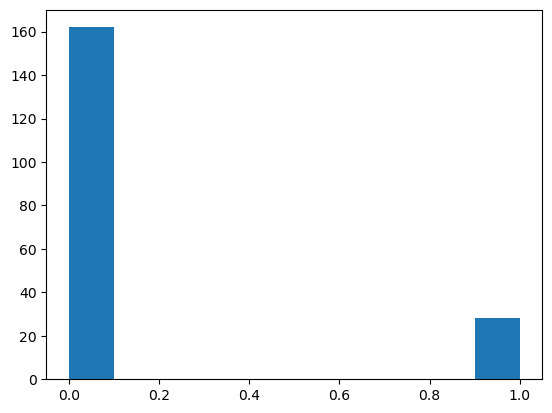

In [111]:
# check the distribution of 0's and 1's
plt.hist(q_final_df['2qtr'])

<span style="color:green">
<p style="text-align: center;"> <i>Fig 5.1 - Distribution of target variable</i></p>
</span>

## 6. Create the monthy and quarterly datasets with "%age change" variables and remove nulls

In [112]:
# Create the quarterly dataset with percentage change instead of absolute values
pct_q_final_df = q_final_df.copy()
pct_q_final_df['CPI_chg'] = pct_q_final_df['CPI'].pct_change()*100
pct_q_final_df['UNRATE_chg'] = pct_q_final_df['UNRATE'].pct_change()*100
pct_q_final_df['GDP_chg'] = pct_q_final_df['GDP'].pct_change()*100
pct_q_final_df['USSTHPI_chg'] = pct_q_final_df['USSTHPI'].pct_change()*100
pct_q_final_df['IntRate_chg'] = pct_q_final_df['IntRate'].pct_change()*100
pct_q_final_df['Gold_Price_chg'] = pct_q_final_df['Gold_Price'].pct_change()*100

#drop the absolute value columns
pct_q_final_df.drop(columns=['CPI','UNRATE','GDP','USSTHPI','IntRate','Gold_Price'], inplace=True)

print("Dataset size before drop: {}".format(pct_q_final_df.shape[0]))
#remove the records with null and infinite values
pct_q_final_df.replace([np.inf, -np.inf], np.nan, inplace=True)
pct_q_final_df = pct_q_final_df.dropna(axis=0)
print("Dataset size after drop: {}".format(pct_q_final_df.shape[0]))

Dataset size before drop: 190
Dataset size after drop: 188


In [113]:
# Create the monthly dataset with percentage change instead of absolute values
pct_m_final_df = m_final_df.copy()
pct_m_final_df['CPI_chg'] = pct_m_final_df['CPI'].pct_change()*100
pct_m_final_df['UNRATE_chg'] = pct_m_final_df['UNRATE'].pct_change()*100
pct_m_final_df['GDP_chg'] = pct_m_final_df['GDP'].pct_change()*100
pct_m_final_df['USSTHPI_chg'] = pct_m_final_df['USSTHPI'].pct_change()*100
pct_m_final_df['IntRate_chg'] = pct_m_final_df['IntRate'].pct_change()*100
pct_m_final_df['Gold_Price_chg'] = pct_m_final_df['Gold_Price'].pct_change()*100

#drop the absolute value columns
pct_m_final_df.drop(columns=['CPI','UNRATE','GDP','USSTHPI','IntRate','Gold_Price'], inplace=True)

print("Dataset size before drop: {}".format(pct_m_final_df.shape[0]))
#remove the records with null and infinite values
pct_m_final_df.replace([np.inf, -np.inf], np.nan, inplace=True)
pct_m_final_df = pct_m_final_df.dropna(axis=0)
print("Dataset size after drop: {}".format(pct_m_final_df.shape[0]))

Dataset size before drop: 569
Dataset size after drop: 565


## 7. Create the clean monthly and quarterly datasets for model fitting

In [114]:
# create the copies of datasets
cp_m_final_df = m_final_df.copy()
cp_q_final_df = q_final_df.copy()
cp_pct_q_final_df = pct_q_final_df.copy()
cp_pct_m_final_df = pct_m_final_df.copy()

#remove the DATE and recession fields
cp_m_final_df.drop(columns=['recession','DATE'], inplace=True)
cp_q_final_df.drop(columns=['recession','DATE'], inplace=True)
cp_pct_q_final_df.drop(columns=['recession','DATE'], inplace=True)
cp_pct_m_final_df.drop(columns=['recession','DATE'], inplace=True)

## 8. Build the Logistic regression models on monthly and quarterly datasets for recession prediction

In [115]:
# fit the logistic regression model for the 4 datasets

# 1- Monthly Dataset with absolute values
X_train1, X_test1, y_train1, y_test1,preds1, log_mod1, score1 = fit_logistic_regression(cp_m_final_df, '2qtr', 0.30)
# 2- Quarterly Dataset with absolute values
X_train2, X_test2, y_train2, y_test2,preds2, log_mod2, score2 = fit_logistic_regression(cp_q_final_df, '2qtr', 0.30)
# 3- Quarterly Dataset with percentage change values
X_train3, X_test3, y_train3, y_test3,preds3, log_mod3, score3 = fit_logistic_regression(cp_pct_q_final_df, '2qtr', 0.30)
# 4- Monthly Dataset with percentage change values
X_train4, X_test4, y_train4, y_test4,preds4, log_mod4, score4 = fit_logistic_regression(cp_pct_m_final_df, '2qtr', 0.30)


## 9. Analyze the metrics for the models and answer Q1

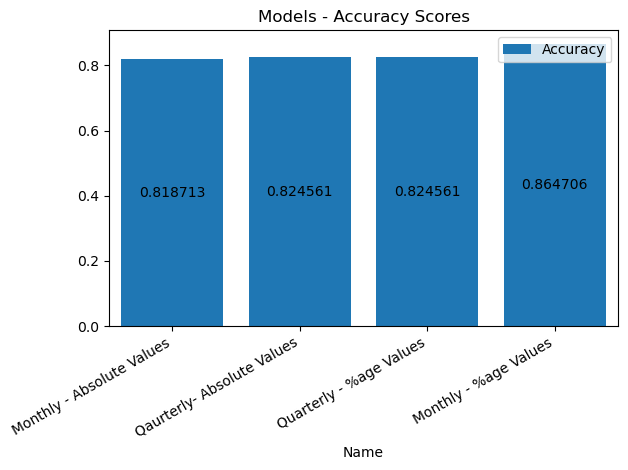

In [116]:
# Model Names
dataset_names = ["Monthly - Absolute Values","Qaurterly- Absolute Values","Quarterly - %age Values", "Monthly - %age Values"]

# Plot the report on accuracy scores of the models
ind = np.arange(4)
accuracy_data = {'Name': dataset_names,
               'Accuracy': [score1, score2, score3, score4]}
accuracy_report_data = pd.DataFrame(accuracy_data,index=dataset_names)

ax_accuracy = accuracy_report_data.plot.bar(x='Name', y = 'Accuracy',rot=0 )
bars = ax_accuracy.bar(ind, accuracy_report_data['Accuracy'])
ax_accuracy.bar_label(bars, label_type='center')
ax_accuracy.set_title("Models - Accuracy Scores")
plt.setp(ax_accuracy.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()
plt.show()

<span style="color:green">
<p style="text-align: center;"> <i>Fig 9.1 - Model Accuracy Scores</i></p>
</span>

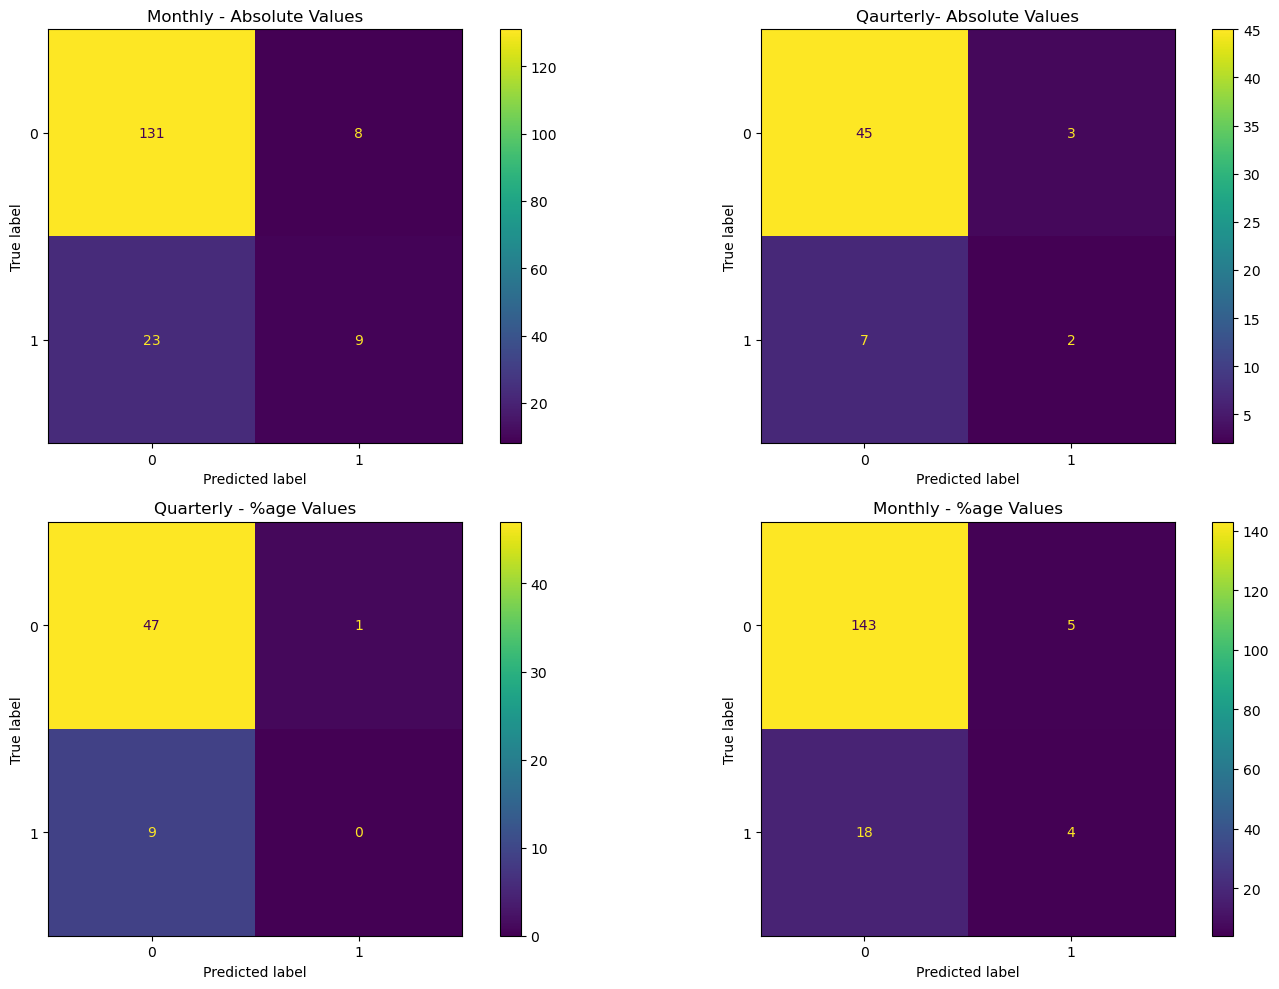

In [117]:
# Plot the Confusion Matrix
f, axes = plt.subplots(2, 2, figsize=(15, 10))
# Model-1
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(y_test1,preds1), display_labels=log_mod1.classes_)
disp.plot(ax=axes[0,0])
disp.ax_.set_title(dataset_names[0])
#Model-2
disp2 = metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(y_test2,preds2), display_labels=log_mod2.classes_)
disp2.plot(ax=axes[0,1])
disp2.ax_.set_title(dataset_names[1])
#Model-3
disp3 = metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(y_test3,preds3), display_labels=log_mod3.classes_)
disp3.plot(ax=axes[1,0])
disp3.ax_.set_title(dataset_names[2])
# Model-4
disp4 = metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(y_test4,preds4), display_labels=log_mod4.classes_)
disp4.plot(ax=axes[1,1])
disp4.ax_.set_title(dataset_names[3])
plt.tight_layout()
plt.show()

<span style="color:green">
<p style="text-align: center;"> <i>Fig 9.2 - Confusion Matrices for the trained models</i></p>
</span>

In [118]:
# Create the metrics reports for each of the 4 models

# Metrics report on well model perform for predicting if recession will occur (i.e. 1)
binary_report = list()
binary_report.append(metrics.precision_recall_fscore_support(y_test1,preds1,average='binary'))
binary_report.append(metrics.precision_recall_fscore_support(y_test2,preds2,average='binary'))
binary_report.append(metrics.precision_recall_fscore_support(y_test3,preds3,average='binary'))
binary_report.append(metrics.precision_recall_fscore_support(y_test4,preds4,average='binary'))

# Metrics report on well model perform on whether recession happens or not (i.e. weighted average of 0 and 1)
weighted_report = list()
weighted_report.append(metrics.precision_recall_fscore_support(y_test1,preds1,average='weighted'))
weighted_report.append(metrics.precision_recall_fscore_support(y_test2,preds2,average='weighted'))
weighted_report.append(metrics.precision_recall_fscore_support(y_test3,preds3,average='weighted'))
weighted_report.append(metrics.precision_recall_fscore_support(y_test4,preds4,average='weighted'))


## Prepare the datasets for plotting

# Plotting dataset on well model perform for predicting if recession will occur (i.e. 1)
binary_data = {'Name': dataset_names,
    'Precision': [binary_report[0][0], binary_report[1][0], binary_report[2][0], binary_report[3][0]],
    'Recall': [binary_report[0][1], binary_report[1][1], binary_report[2][1], binary_report[3][1]],
    'F1-Score': [binary_report[0][2], binary_report[1][2], binary_report[2][2], binary_report[3][2]]}

binary_report_data = pd.DataFrame(binary_data,index=dataset_names)

# Plotting dataset on well model perform on whether recession happens or not (i.e. weighted average of 0 and 1)
weighted_data = {'Name': dataset_names,
    'Precision': [weighted_report[0][0], weighted_report[1][0], weighted_report[2][0], weighted_report[3][0]],
    'Recall': [weighted_report[0][1], weighted_report[1][1], weighted_report[2][1], weighted_report[3][1]],
    'F1-Score': [weighted_report[0][2], weighted_report[1][2], weighted_report[2][2], weighted_report[3][2]]}

weighted_report_data = pd.DataFrame(weighted_data,index=dataset_names)



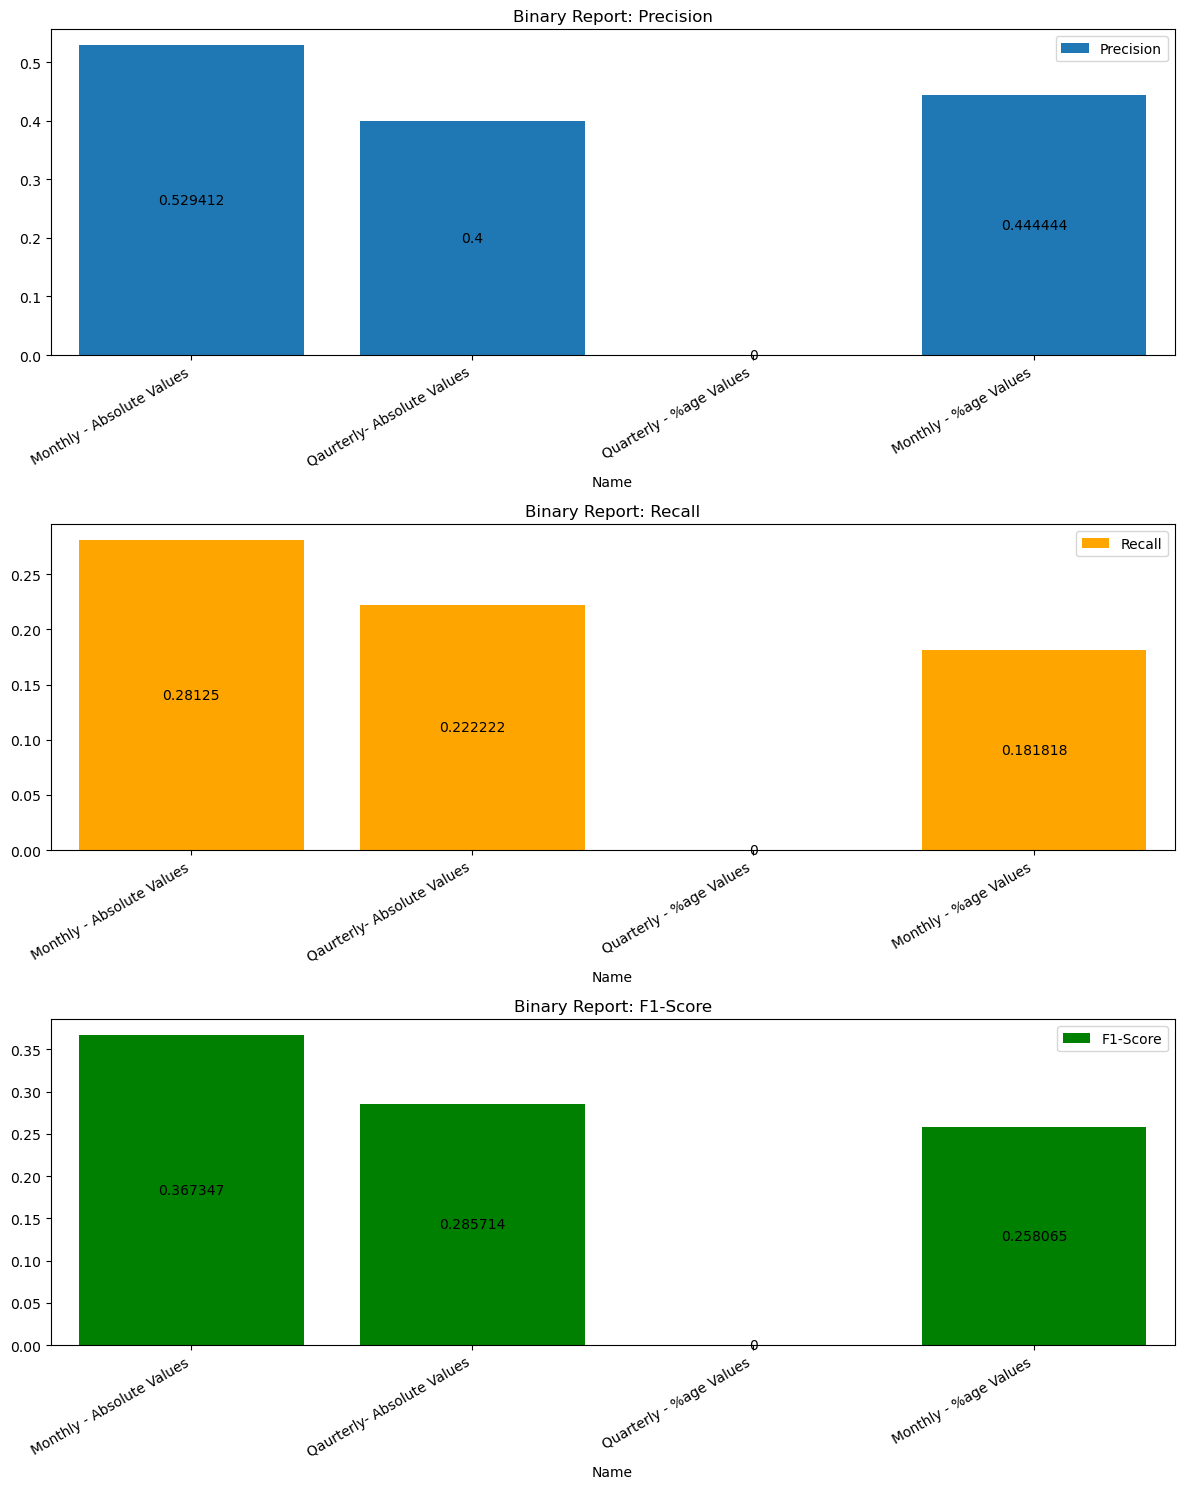

In [119]:
# Plot the reports for Binary Report Dataset

f, axes = plt.subplots(3, 1, figsize=(12, 15))
ax1 = binary_report_data.plot.bar(x='Name', y = 'Precision',rot=0,ax=axes[0] )
bars1 = ax1.bar(ind, binary_report_data['Precision'])
ax1.bar_label(bars1, label_type='center')
ax1.set_title("Binary Report: Precision")
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

ax2 = binary_report_data.plot.bar(x='Name', y = 'Recall',color='orange',rot=0,ax=axes[1])
bars2 = ax2.bar(ind, binary_report_data['Recall'],color='orange')
ax2.bar_label(bars2, label_type='center')
ax2.set_title("Binary Report: Recall")
plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment='right')

ax3 = binary_report_data.plot.bar(x='Name', y = 'F1-Score',color='green',rot=0,ax=axes[2])
bars3 = ax3.bar(ind, binary_report_data['F1-Score'],color='green')
ax3.bar_label(bars3, label_type='center')
ax3.set_title("Binary Report: F1-Score")
plt.setp(ax3.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.tight_layout()
plt.show()

<span style="color:green">
<p style="text-align: center;"> <i>Fig 9.3 - Binary Metrics for the trained models</i></p>
</span>

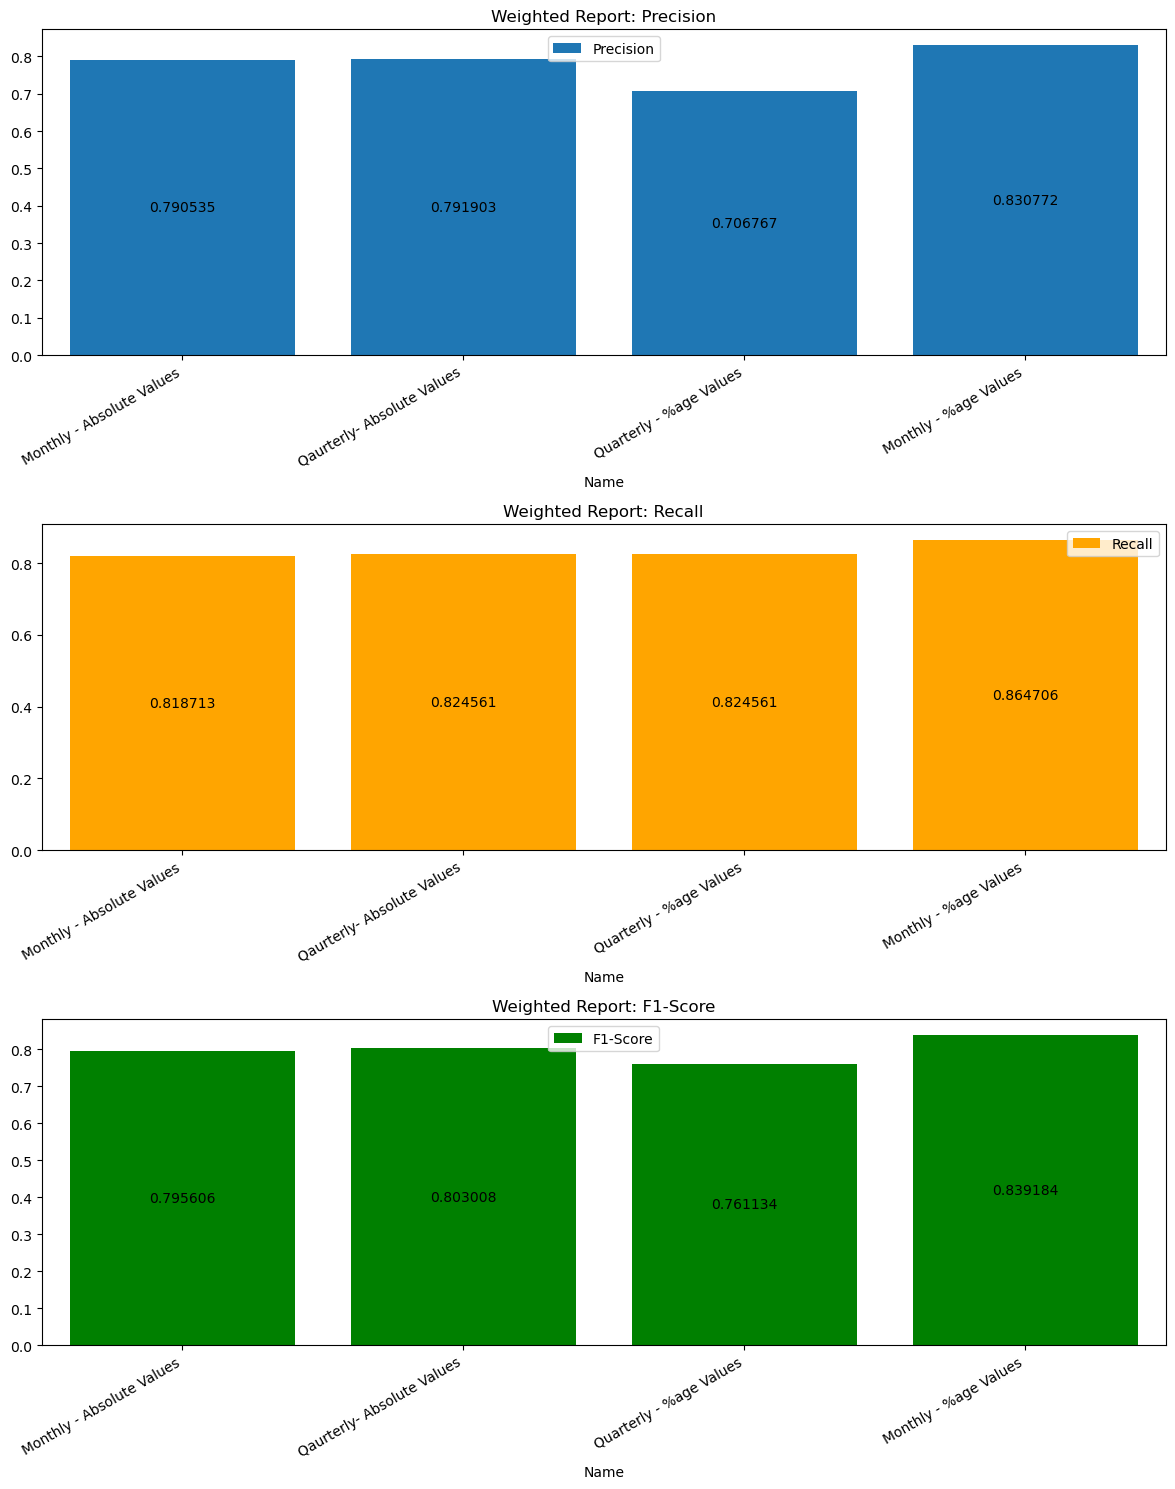

In [120]:
# Plot the reports for Weighted Report Dataset

f, axes = plt.subplots(3, 1, figsize=(12, 15))
ax1 = weighted_report_data.plot.bar(x='Name', y = 'Precision',rot=0,ax=axes[0] )
bars1 = ax1.bar(ind, weighted_report_data['Precision'])
ax1.bar_label(bars1, label_type='center')
ax1.set_title("Weighted Report: Precision")
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

ax2 = weighted_report_data.plot.bar(x='Name', y = 'Recall',color='orange',rot=0,ax=axes[1])
bars2 = ax2.bar(ind, weighted_report_data['Recall'],color='orange')
ax2.bar_label(bars2, label_type='center')
ax2.set_title("Weighted Report: Recall")
plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment='right')

ax3 = weighted_report_data.plot.bar(x='Name', y = 'F1-Score',color='green',rot=0,ax=axes[2])
bars3 = ax3.bar(ind, weighted_report_data['F1-Score'],color='green')
ax3.bar_label(bars3, label_type='center')
ax3.set_title("Weighted Report: F1-Score")
plt.setp(ax3.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.tight_layout()
plt.show()

<span style="color:green">
<p style="text-align: center;"> <i>Fig 9.4 - Weighted Metrices for the trained models</i></p>
</span>

<span style="color:navy">
<h1> Q1. How well we can build the recession predictor with the publicly available data?</h1>
<p>1- Looking at the model accuracy figures, the Model fitted with "Monthly %age Change" data (Model-4) looks the best - followed by 
    quarterly models (Model-2 and Model-3) and finally the one fitted with "Monthly Asbsolute data"(Model-1) [ref Fig 9.1]
   <br> 2- However, on observing the confusion matrices of the models [Fig 9.2], we can see that Model-1 has the highest number of True-
    Positives, followed by Model-4. Model-3 is the worst and Model-2 has couple of True-positives only</br>
   3- Above behaviour points to the fact that accuracy figures are driven by the imbalance in the binary target variable, where number of
    0s is almost 4 times the number of 1's. This observation is also supported by Fig 5.1 [ref Fig 5.1] </br>
   4- Now by analyzing the Binary and Weighted metrics of the models [ref Fig 9.3 and Fig 9.4], we can conclude that the best predictor for the recession (i.e. predicting 1) is Model-1, while Model-4 is providing the best weighted prediction for either outcome (i.e. predicting 0 or 1). Model-3 is quite useless, and Model-2 is providing similar results as Model-4 </br>
   5- Therefore, we can conclue that none of the model is providing ideal metrics. However, <b>we'll pick Model-1 and Model-4 </b> for the further analysis and prediciton
    </p>
    
    
</span>

## 10. Analyze the model coefficients and answer Q2

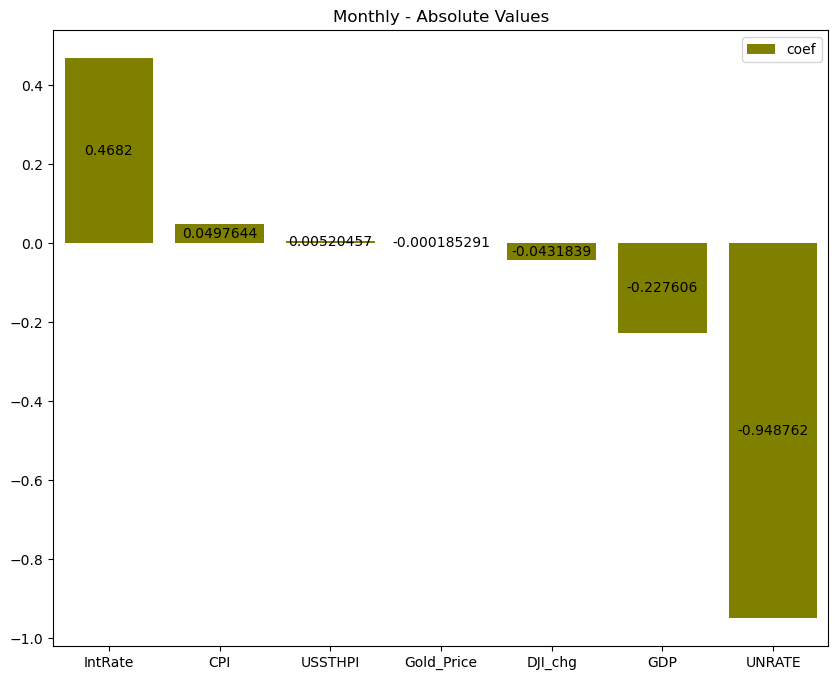

In [121]:
# Plot the coefficients of the selected models 
plot_log_model_coefficients(log_mod1,X_train1.columns,dataset_names[0],'olive')


<span style="color:green">
<p style="text-align: center;"> <i>Fig 10.1 - Model Coefficients - Model trained with Monthly Absolute variables</i></p>
</span>

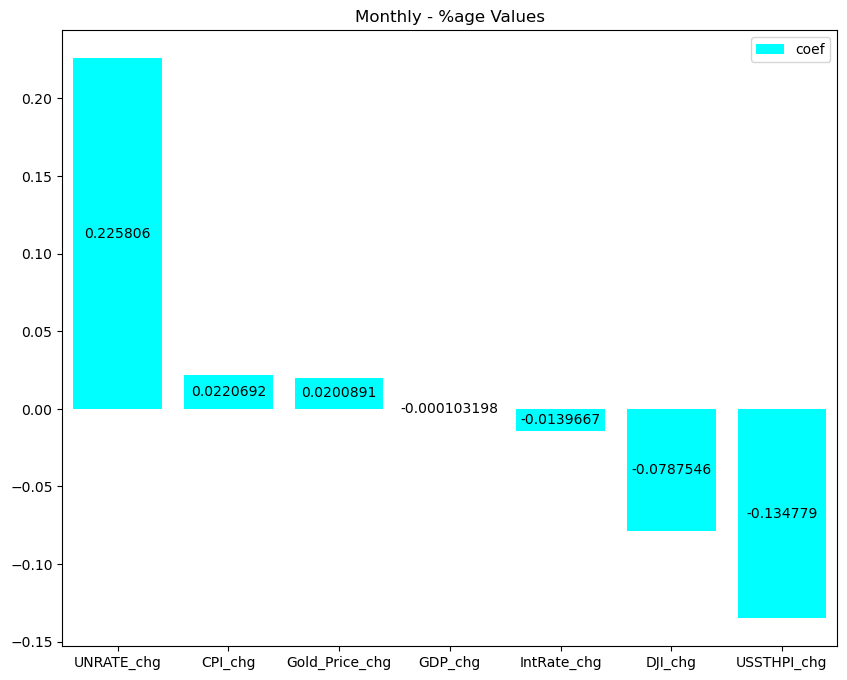

In [122]:
plot_log_model_coefficients(log_mod4,X_train4.columns,dataset_names[3],'cyan')

<span style="color:green">
<p style="text-align: center;"> <i>Fig 10.2 - Model Coefficients - Model trained with Monthly %age change variables</i></p>
</span>

<span style="color:navy">
<h1> Q2. What are the key factors to predict recession?</h1>
<p>1- Looking at the coefficients of Model-1 i.e. model fitted with "Monthly Asbsolute data"[ref Fig 10.1],  we can conclude that unemployment rate, interest rate and GDP have the highest effect on the prediction respectively
   <br> 2- For the Model-4 i.e. model fitted with "Monthly %age Change data" [ref Fig 10.2],the uneployment rate, housing price index and the DJI have highest effect on the prediction respectively </br>
   3- Unemployment rate is the only factor common to both the models. However, the relation is positive for Model-4 vs negative for Model-1  </br>
   4- It seems counter-intuitive that decrease in unemployment rate will point to the onset of recession as suggested by Model-1 coefficients. However, this requires more data nd deeper analysis to test this opinion </br></p>
    
    

## 11. Load the 2022 datasets, generate 2023 predictions and answer Q3

In [123]:
# load the input data files for the selected models
pct_pred_data = pd.read_csv('./pred_data/X_2022_pct.csv')
abs_pred_data = pd.read_csv('./pred_data/X_2022.csv')

# create the prediction dataframe with the DATE column
pred_results = pd.DataFrame(abs_pred_data['DATE'])

#drop undesired columns for the prediction
abs_pred_data.drop('DATE', axis=1, inplace=True)
pct_pred_data.drop('DATE', axis=1, inplace=True)

#generate the predictions
mod1_pred = log_mod1.predict(abs_pred_data)
mod4_pred = log_mod4.predict(pct_pred_data)

# add to the result dataframe
pred_results.insert(1, 'Model1 Prediction', mod1_pred)
pred_results.insert(2, 'Model4 Prediction', mod4_pred)

print(pred_results)


       DATE  Model1 Prediction  Model4 Prediction
0    1/1/22                  0                  0
1    1/2/22                  0                  0
2    1/3/22                  0                  0
3    1/4/22                  1                  0
4    1/5/22                  1                  0
5    1/6/22                  1                  0
6    1/7/22                  0                  0
7    1/8/22                  1                  0
8    1/9/22                  1                  0
9   1/10/22                  1                  0
10  1/11/22                  1                  0
11  1/12/22                  1                  0


<span style="color:green">
<p style="text-align: center;"> <i>Fig 11.1 - Predicted Recession indicator by the 2 trained models</i></p>
</span>

<span style="color:navy">
<h1> Q3. What is the prediction for recession in 2023 using selected models?</h1>
<p>1- Based on the predicted results [ref Fig 11.1], Model-1 is predicting recession towards the end of 2022 and continuing in Q1 and Q2 of 2023
   <br> 2- On the other hand, Model-4 is not predicting recession in first half of 2023 </br>
   3- Now knowing that recession didn't occur in Q4 2022 and considering Model-1 and Model-4 are differing on this prediction, we don't have a strong prediction on a recession occuring in first-half 2023  </br>
   <b> So, let's not be anxious and hope for a happy and prosperous 2023! :-)</b> </br></p>

# Conclusion
The F1-scores and other metrics of all the models are not very promising. Hence, there is a room for improving the accuracy of the results by
1. Sourcing more historical data for the selected variables
2. Add new datasets having better correlation with the recession e.g. trade indexes, specific industrial/manufacturing data, investor sentiments, etc.
3. Use other algorithms e.g. decision trees 

 <p>© Copyright, Rashid Mohiuddin</p>